# Car Data 

### Importing Required Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score


In [4]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, roc_auc_score, roc_curve, log_loss

### Reading The Data

In [7]:
df = pd.read_csv("../Data/car_data.csv")

In [8]:
df.head()

,User ID,Gender,Age,AnnualSalary,Purchased
0,385,Male,35,20000,No
1,681,Male,40,43500,No
2,353,Male,49,74000,No
3,895,Male,40,107500,Yes
4,661,Male,25,79000,No


In [9]:
df.shape

(1000, 5)

## Exploratory Data Analysis

In [10]:
df.isnull().sum()

User ID         0
Gender          0
Age             0
AnnualSalary    0
Purchased       0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   User ID       1000 non-null   int64 
 1   Gender        1000 non-null   object
 2   Age           1000 non-null   int64 
 3   AnnualSalary  1000 non-null   int64 
 4   Purchased     1000 non-null   object
dtypes: int64(3), object(2)
memory usage: 39.2+ KB


In [12]:
df.describe()

,User ID,Age,AnnualSalary
count,1000.000000,1000.000000,1000.000000
mean,500.500000,40.106000,72689.000000
std,288.819436,10.707073,34488.341867
min,1.000000,18.000000,15000.000000
25%,250.750000,32.000000,46375.000000
50%,500.500000,40.000000,72000.000000
75%,750.250000,48.000000,90000.000000
max,1000.000000,63.000000,152500.000000


### Dist Plot


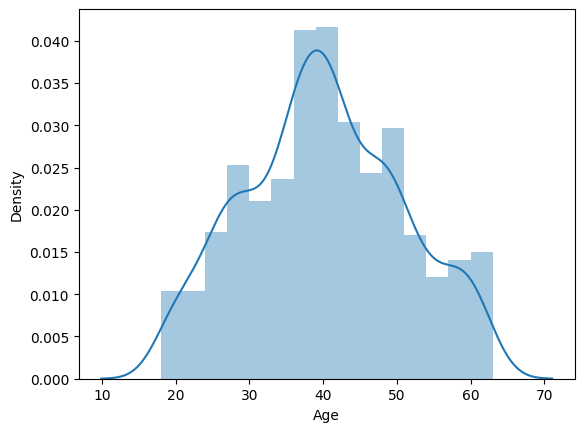

In [13]:
sns.distplot(df['Age']);

### Distplot

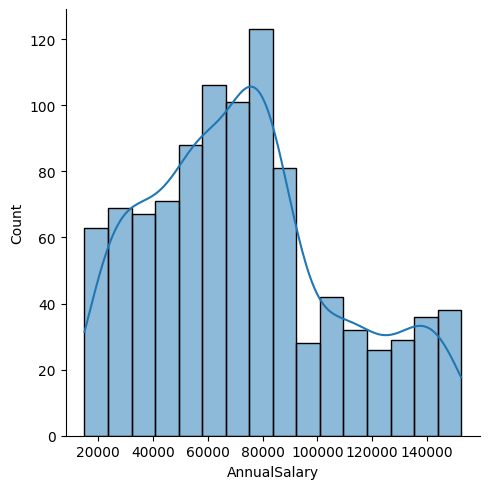

In [14]:
sns.displot(df, x='AnnualSalary', kde=True);

### Scatter Plot
In Scatter plot, We can see there is a change in salary with age. As, trend shows more salary tends to more chance of purchasing car

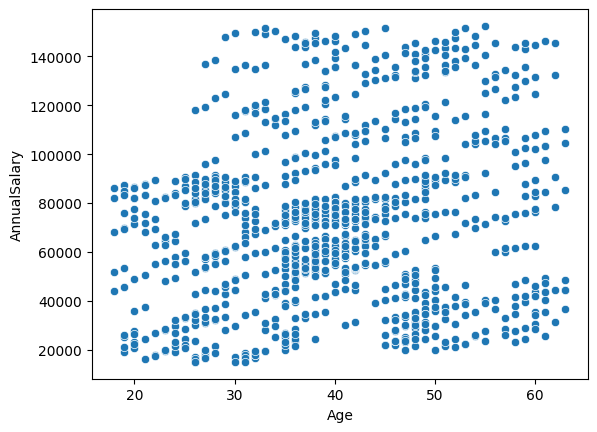

In [15]:
sns.scatterplot(df, x='Age', y='AnnualSalary');

### Heatmap
In The Below heatmap, We Can see the age is quite more correlated to purchasing and secondary is Annual Salary

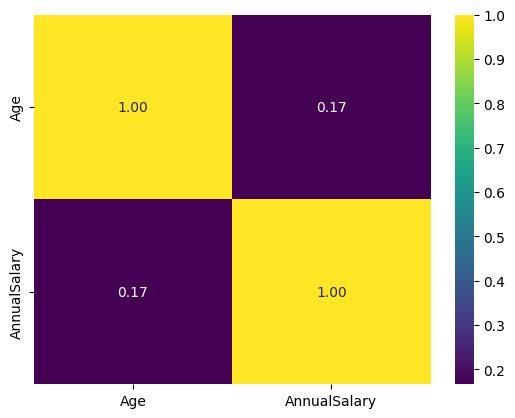

In [16]:
sns.heatmap(df.drop('User ID', axis=1).corr(numeric_only=True), annot=True, fmt='.2f', cmap='viridis');

### Bar Graph
In Bar Graph, It Shows us the difference in data or Imbalanced Dataset

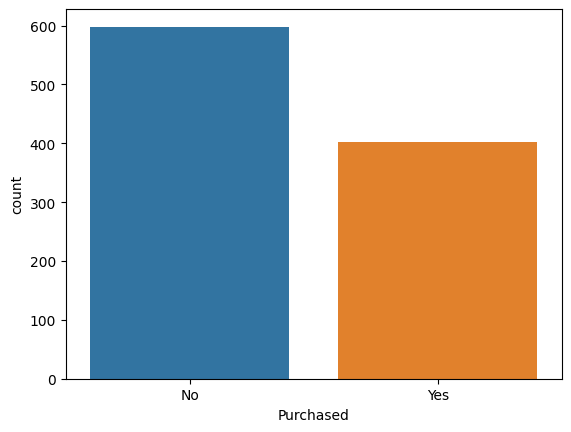

In [17]:
sns.countplot(df, x='Purchased', hue='Purchased');

### Splitting The Dataset

In [18]:
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Feature Engineering

In [20]:
label_encoder = LabelEncoder()

In [21]:
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

#### Function Based Implementation

In [22]:
def Preprocess(input_data: pd.core.frame.DataFrame, feature: str, encoder, scaler, train_data: bool) -> pd.core.frame.DataFrame:
    """
      This Is used to preprocess the model according to the instructions you have provided and returning the results
      For this data encoder is One Hot Encoder
      Scaler Can be Changed
    """
    if train_data:
        input_data[feature] = encoder.fit_transform(input_data[[feature]])
        scaler.fit_transform(input_data)
    else:
        input_data[feature] = encoder.fit(input_data[[feature]])
        scaler.fit(input_data)

    return pd.DataFrame(input_data, columns=input_data.columns)

In [23]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [24]:
y_test = le.transform(y_test)

#### Column Transformer

In [25]:
encoder_transformer = ColumnTransformer([('One Hot Encoder', one_hot_encoder, ['Gender'])], remainder='passthrough')

#### Scaling

In [26]:
scaler_transformer = ColumnTransformer(
    [('Scaler', StandardScaler(), slice(0, 2))]
)

#### Feature Selection

In [30]:
model = LogisticRegression()

#### Pipeline

In [55]:
pipe = Pipeline(
    [("Encoder", encoder_transformer),
    ("Scaler", scaler_transformer),
    ("model", model)]
)

In [56]:
pipe

Pipeline(steps=[('Encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('One Hot Encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender'])])),
                ('Scaler',
                 ColumnTransformer(transformers=[('Scaler', StandardScaler(),
                                                  slice(0, 2, None))])),
                ('model', LogisticRegression())])

In [57]:
X_train.head()

,Gender,Age,AnnualSalary
541,Male,50,29500
440,Female,47,107000
482,Female,42,75000
422,Female,28,59500
778,Female,48,47500


### Training The Model

In [58]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('Encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('One Hot Encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender'])])),
                ('Scaler',
                 ColumnTransformer(transformers=[('Scaler', StandardScaler(),
                                                  slice(0, 2, None))])),
                ('model', LogisticRegression())])

### Testing The Model

In [59]:
pipe.score(X_test, y_test)

0.8133333333333334

### Hyperparameter Tuning

In [63]:
params_grid = {
    'model__C': np.logspace(-4, 4, 20),
    'model__solver': ['lbfgs', 'newton-cg', 'saga'],
    'model__max_iter': [100, 100, 2500, 5000]
}

In [64]:
tuned_model = GridSearchCV(pipe, param_grid=params_grid)

In [65]:
tuned_model.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('Encoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('One '
                                                                         'Hot '
                                                                         'Encoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Gender'])])),
                                       ('Scaler',
                                        ColumnTransformer(transformers=[('Scaler',
                                                                         StandardScaler(),
                                                                         slice(0, 2, None))])),
                                       ('model', LogisticRegression())]),
             param_grid={'m...2796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'model__max_iter': [100, 100, 2500, 5000],
                         'model__solver': ['lbfgs', 'newton-cg', 'saga']})

## Evaluation

In [68]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       172
           1       0.81      0.74      0.77       128

    accuracy                           0.81       300
   macro avg       0.81      0.80      0.81       300
weighted avg       0.81      0.81      0.81       300



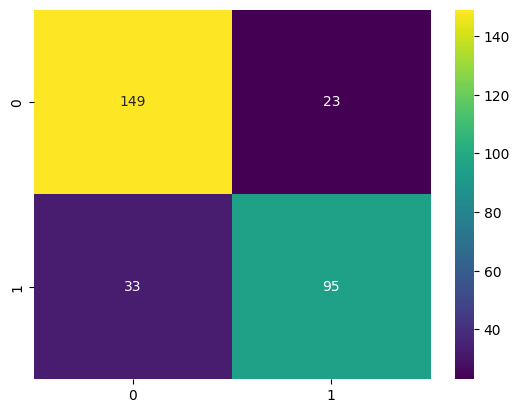

In [69]:
cm1 = confusion_matrix(y_test, pipe.predict(X_test))
sns.heatmap(cm1, annot=True, fmt='0.0f', cmap='viridis');

### ROC Curve

In [70]:
def plot_roc_curve(fpr:np.ndarray , tpr: np.ndarray, roc_auc: np.float64) -> None:
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

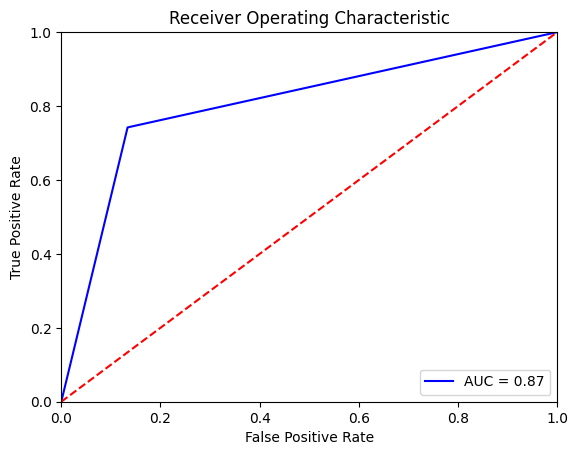

In [71]:
fpr , tpr, threshold = roc_curve(y_test, pipe.predict(X_test))
auc = roc_auc_score(y_test, pipe.predict_proba(X_test)[::, 1])
plot_roc_curve(fpr, tpr, auc)

### Log Loss

In [72]:
log_loss(y_test, pipe.predict(X_test))

6.728148632635202